# Final Project Code Part 2: AE On CIFAR10

**Name: Yiqun Hao**

**Content**: In this notebook:

1. I used the rewritten code and did some experiments on CIFAR10: a much more complex and realistic dataset compared to MNIST.

#### Import all packages used in this notebook

In [27]:
# Main package: PyTorch
import torch
# TorchVision contains image datasets
import torchvision
# Our networks
import torch.nn as nn
# Our activation
import torch.nn.functional as F
# Optimizer
import torch.optim as optim

# Draw graphs to visualize
import matplotlib.pyplot as plt
import numpy as np

#### 0. Check GPU

In [28]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


#### CAE Model Parameters

In [29]:
# lambda's are the ratios between the four error terms
# lambda_class = 20
lambda_class = 2
lambda_ae = 2
lambda_1 = 1              # 1 and 2 here corresponds to the notation we used in the paper
lambda_2 = 1

# the number of prototypes
n_prototypes = 10

#### 1. We first import dataset

In [30]:
n_epochs = 100
batch_size = 100
learning_rate = 0.001
momentum = 0.5
random_seed = 1
torch.manual_seed(random_seed)

In [31]:
# 1. We first construct a transform to normalize image data
transform = torchvision.transforms.Compose([
    # To [0,1]
    torchvision.transforms.ToTensor(),
    # To [-1,1] first () is the mean of RGB second () is the std of RBG
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
# 2. We import data
train_set = torchvision.datasets.CIFAR10(root='./dataset',train=True,download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./dataset',train=False,download=True,transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


#### 2. We construct our network 

##### 2. Encoder

In [32]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 128, 1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv8 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv10 = nn.Conv2d(256, 256, 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 1, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()

        self.fc14 = nn.Linear(512 * 4 * 4, 1024)
        self.drop1 = nn.Dropout2d()
        self.fc15 = nn.Linear(1024, 1024)
        self.drop2 = nn.Dropout2d()
        self.fc16 = nn.Linear(1024, 40)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        # print(" x shape ",x.size())
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc14(x))
        x = self.drop1(x)
        x = F.relu(self.fc15(x))
        x = self.drop2(x)
        x = self.fc16(x)
        
        return x
print(Encoder())

Encoder(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=1, 

##### 3. Decoder

In [33]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc1 = nn.Linear(40, 100)
    self.deconv1 = nn.ConvTranspose2d(4, 32, kernel_size=6)
    self.deconv2 = nn.ConvTranspose2d(32, 64, kernel_size=6)
    self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=6)
    self.deconv4 = nn.ConvTranspose2d(32, 16, kernel_size=6)
    self.deconv5 = nn.ConvTranspose2d(16, 8, kernel_size=6)
    self.deconv6 = nn.ConvTranspose2d(8, 3, kernel_size=3)

  def forward(self, x):
    # Problem: need to check this shape
    x = F.relu(self.fc1(x))
    
    x = x.view(-1, 4, 5, 5)
    
    x = F.relu(self.deconv1(x))
    x = F.relu(self.deconv2(x))
    x = F.relu(self.deconv3(x))
    x = F.relu(self.deconv4(x))
    x = F.relu(self.deconv5(x))
    x = F.relu(self.deconv6(x))
    
    return x
print(Decoder())

Decoder(
  (fc1): Linear(in_features=40, out_features=100, bias=True)
  (deconv1): ConvTranspose2d(4, 32, kernel_size=(6, 6), stride=(1, 1))
  (deconv2): ConvTranspose2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
  (deconv3): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(1, 1))
  (deconv4): ConvTranspose2d(32, 16, kernel_size=(6, 6), stride=(1, 1))
  (deconv5): ConvTranspose2d(16, 8, kernel_size=(6, 6), stride=(1, 1))
  (deconv6): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
)


##### 4. Prototype Classification Network

In [34]:
# Functions used to calculate the distance between encoded_input and prototype vectors
def list_of_distances(X, Y):
    '''
    Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
    Y = [y_1, ... , y_m], we return a list of vectors
            [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
             ...
             [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
    where the distance metric used is the sqared euclidean distance.
    The computation is achieved through a clever use of broadcasting.
    '''
    XX = list_of_norms(X).view(-1, 1)
    YY = list_of_norms(Y).view(1, -1)
    output = XX + YY - 2 * torch.matmul(X, Y.t())

    return output

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X,2), axis=1)

In [35]:
class PCN(nn.Module):
  def __init__(self):
    super(PCN, self).__init__()
    self.prototype_feature_vectors = nn.Parameter(torch.rand(n_prototypes, 10*2*2))
#     self.weight = nn.Parameter(torch.randn(n_prototypes, 10))



# x.shape:  torch.Size([100, 10, 2, 2])
# feature_vectors.shape:  torch.Size([100, 40])
# prototype_feature_vectors.shape:  torch.Size([10, 40])
# feature_vector_distances.shape is the list of distances from each prototype to every x_i in the latent space:  torch.Size([10, 100])
# prototype_distances.shape is the list of distances from each x_i to every prototype in the latent space :  torch.Size([100, 10])
  def forward(self, x):
        
    # Flatten layer
    feature_vectors = x.view(-1, 10 * 2 * 2)
    
    # ----------------------------------------------------------------------------------------------------------
    # Prototype layer
    prototype_distances = list_of_distances(feature_vectors, self.prototype_feature_vectors)
    
    feature_vector_distances = list_of_distances(self.prototype_feature_vectors, feature_vectors)
    
    
    # ----------------------------------------------------------------------------------------------------------
    
    # Fully-connected layer
    output = prototype_distances * -1
    # output = torch.matmul(prototype_distances, self.weight.data)
    
    return output, prototype_distances, feature_vector_distances, self.prototype_feature_vectors
print(PCN())

PCN()


#### Overall Model

In [36]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.pcn = PCN()

    def forward(self, x):
        encoded_input = self.encoder(x)
        decoded_input = self.decoder(encoded_input)
        output, prototype_distances, feature_vector_distances, prototype_vectors = self.pcn(encoded_input)
        return encoded_input, decoded_input, output, prototype_distances, feature_vector_distances, prototype_vectors
    
    
    def presentPrototype(self, prototype_vectors, Prototype):
        decoded_prototypes = self.decoder(prototype_vectors).cpu()
        fig = plt.figure()
        if Prototype:
            plt.subplots_adjust(hspace=0.5)
            for index, x in enumerate(decoded_prototypes):
                plt.subplot(5,2,index+1)
                img = torchvision.utils.make_grid(x)
                img = img / 2 + 0.5     # unnormalize
                npimg = img.numpy()
                plt.imshow(np.transpose(npimg, (1, 2, 0)))
#                 plt.title("P{}".format(index+1))
                plt.xticks([])
                plt.yticks([])
        else:
            print("Not Prototype: ",decoded_prototypes[0].shape)
            img = torchvision.utils.make_grid(decoded_prototypes[0])
            img = img / 2 + 0.5     # unnormalize
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
            plt.title("Reconstructed Sample Input")
            plt.xticks([])
            plt.yticks([])
        plt.show()
print(MyModel())

MyModel(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (pool

#### Loss Function

In [37]:
'''
the error function consists of 4 terms, the autoencoder loss,
the classification loss, and the two requirements that every feature vector in
X look like at least one of the prototype feature vectors and every prototype
feature vector look like at least one of the feature vectors in X.
'''
class LossFunc(nn.Module):
    def __init__(self):
        super(LossFunc, self).__init__()
        self.crossLoss = nn.CrossEntropyLoss()

    def forward(self, outputs, labels, images, X_decoded, feature_vector_distances, prototype_distances):
        class_error = self.crossLoss(outputs,labels)
        ae_error = torch.mean(list_of_norms(X_decoded - images))
        error_1 = torch.mean(torch.min(feature_vector_distances, axis = 1).values)
        error_2 = torch.mean(torch.min(prototype_distances, axis = 1).values)
        total_error = lambda_class * class_error +\
                      lambda_ae * ae_error +\
                      lambda_1 * error_1 +\
                      lambda_2 * error_2
        return class_error, ae_error, error_1, error_2, total_error # 注意最后只能返回Tensor值，且带梯度，即 loss.requires_grad == True

#### 3. We train our network on training dataset and evaluate them on the test set

In [38]:
# 1. Initial networks
model = MyModel()
model = model.cuda()

# 3. Store things for visualizing results
accuracy_values=[]
total_loss_values=[]
ae_loss_values=[]
error1_loss_values=[]
error2_loss_values=[]
class_loss_values=[]
epoch_number=range(n_epochs)



# 4. Begin training
criterion = LossFunc()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) 

for epoch in epoch_number:
    running_loss = 0.0
    running_class = 0.0
    running_ae = 0.0
    running_e1 = 0.0
    running_e2 = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        encoded_input, decoded_input, output, prototype_distances, feature_vector_distances, _ = model(inputs)
        # X_true not defined
        class_error, ae_error, error_1, error_2, total_error = criterion(output, labels, inputs, decoded_input, feature_vector_distances, prototype_distances)
        total_error.backward()
        optimizer.step()

        # print statistics
        running_loss += total_error.item()
        running_class += class_error.item()
        running_ae += ae_error.item()
        running_e1 += error_1.item()
        running_e2 += error_2.item()
    
        if i % 500 == 499:    # print every 6000 mini-batches (12500 batches in total)
            print('[epoch: %d, itr: %5d] total_loss: %.6f class_error: %.6f ae_error: %.6f error_1: %.6f error_2: %.6f' %
                (epoch + 1, i + 1, running_loss/100, running_class/100, running_ae/100, running_e1/100, running_e2/100))

            total_loss_values.append(running_loss/100)
            ae_loss_values.append(running_ae/100)
            error1_loss_values.append(running_e1/100)
            error2_loss_values.append(running_e2/100)
            class_loss_values.append(running_class/100)

            running_loss = 0.0
            running_class = 0.0
            running_ae = 0.0
            running_e1 = 0.0
            running_e2 = 0.0


    # Evaluate our dataset on test set
    correct = 0
    total = 0
    # Make parameters stay the same without updating
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        encoded_input, decoded_input, output, prototype_distances, feature_vector_distances, prototype_vectors = model(images)
        # Return the value, index pair of the biggest element. Max function 1 means the biggest in each row, 0 means biggest in each column
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu()==labels.cpu()).sum().item()
        
#       model.presentPrototype(prototype_vectors)
#       model.presentDecoded(encoded_input)
      TestAccuracy = 100 * correct / total;
      accuracy_values.append(TestAccuracy) 
      print('Epoch=%d Test Accuracy=%.2f%%' %
                (epoch + 1, TestAccuracy))
    
    

print('Finished Here!')

[epoch: 1, itr:   500] total_loss: 40.704261 class_error: 9.096899 ae_error: 3.847576 error_1: 6.036341 error_2: 8.778972
Epoch=1 Test Accuracy=50.08%
[epoch: 2, itr:   500] total_loss: 27.301614 class_error: 6.739013 ae_error: 3.839922 error_1: 1.816439 error_2: 4.327305
Epoch=2 Test Accuracy=57.58%
[epoch: 3, itr:   500] total_loss: 23.427889 class_error: 5.707441 ae_error: 3.839868 error_1: 1.147857 error_2: 3.185413
Epoch=3 Test Accuracy=64.25%
[epoch: 4, itr:   500] total_loss: 21.427173 class_error: 5.060187 ae_error: 3.839842 error_1: 0.898548 error_2: 2.728566
Epoch=4 Test Accuracy=68.15%
[epoch: 5, itr:   500] total_loss: 20.013012 class_error: 4.566528 ae_error: 3.839823 error_1: 0.752541 error_2: 2.447770
Epoch=5 Test Accuracy=71.52%
[epoch: 6, itr:   500] total_loss: 18.842189 class_error: 4.124018 ae_error: 3.839808 error_1: 0.650857 error_2: 2.263679
Epoch=6 Test Accuracy=72.71%
[epoch: 7, itr:   500] total_loss: 17.898131 class_error: 3.742923 ae_error: 3.839797 error_1:

[epoch: 55, itr:   500] total_loss: 8.506402 class_error: 0.078048 ae_error: 3.839787 error_1: 0.102671 error_2: 0.568060
Epoch=55 Test Accuracy=79.06%
[epoch: 56, itr:   500] total_loss: 8.488504 class_error: 0.076067 ae_error: 3.839787 error_1: 0.101411 error_2: 0.555385
Epoch=56 Test Accuracy=78.80%
[epoch: 57, itr:   500] total_loss: 8.487633 class_error: 0.074528 ae_error: 3.839787 error_1: 0.101538 error_2: 0.557465
Epoch=57 Test Accuracy=78.64%
[epoch: 58, itr:   500] total_loss: 8.473480 class_error: 0.073918 ae_error: 3.839787 error_1: 0.104139 error_2: 0.541930
Epoch=58 Test Accuracy=79.03%
[epoch: 59, itr:   500] total_loss: 8.467058 class_error: 0.072503 ae_error: 3.839787 error_1: 0.098716 error_2: 0.543761
Epoch=59 Test Accuracy=78.81%
[epoch: 60, itr:   500] total_loss: 8.454826 class_error: 0.071617 ae_error: 3.839787 error_1: 0.096484 error_2: 0.535533
Epoch=60 Test Accuracy=78.75%
[epoch: 61, itr:   500] total_loss: 8.452308 class_error: 0.070441 ae_error: 3.839787 er

#### 5. Visualize our results

Ground Truth:  torch.Size([3, 32, 32])


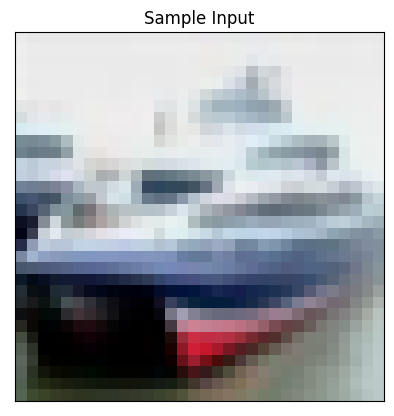

C:\Users\EZRA\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


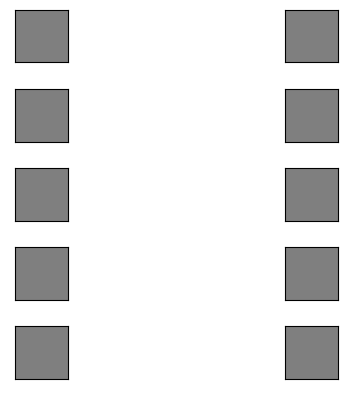

Not Prototype:  torch.Size([3, 32, 32])


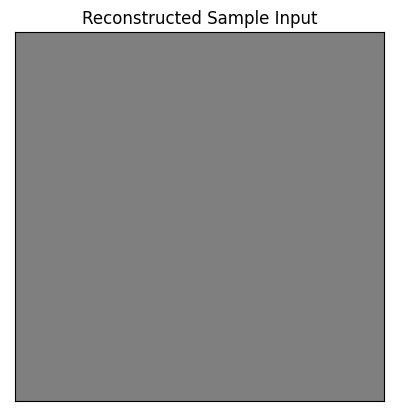

In [48]:
# get some random training images
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# show images
fig = plt.figure()
print("Ground Truth: ",example_data[1].shape)
img = torchvision.utils.make_grid(example_data[1])
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))


plt.title("Sample Input")
plt.xticks([])
plt.yticks([])
plt.show()




example_data = example_data[1].unsqueeze(dim=0).cuda()
with torch.no_grad():
    encoded_input, decoded_input, output, prototype_distances, feature_vector_distances, prototype_vectors = model(example_data)
    model.presentPrototype(prototype_vectors, True)
    model.presentPrototype(encoded_input, False)

Performance Evalution

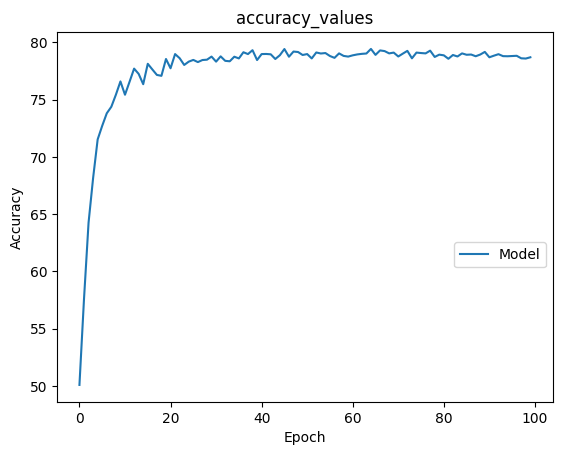

In [40]:
# First we check values we have so far
# print('accuracy_values', accuracy_values)
# print('epoch_number', epoch_number)
# Plot the data
plt.plot(epoch_number, accuracy_values, label='Model')  
plt.title('accuracy_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('Accuracy')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

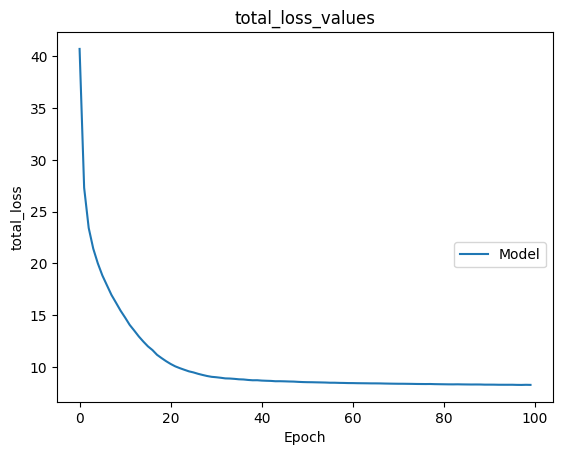

In [41]:
# Plot the data
plt.plot(epoch_number, total_loss_values, label='Model')  
plt.title('total_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('total_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

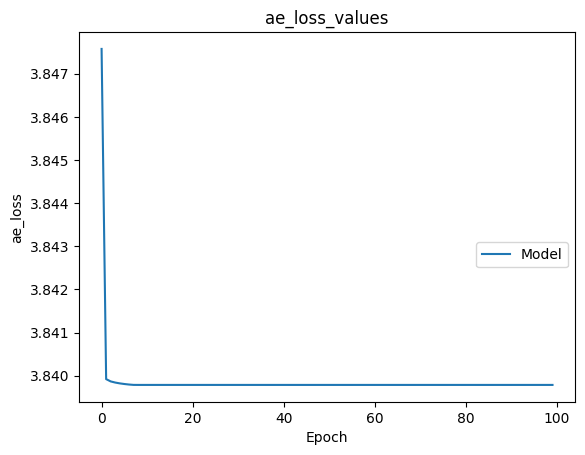

In [42]:
# Plot the data
plt.plot(epoch_number, ae_loss_values, label='Model')  
plt.title('ae_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('ae_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

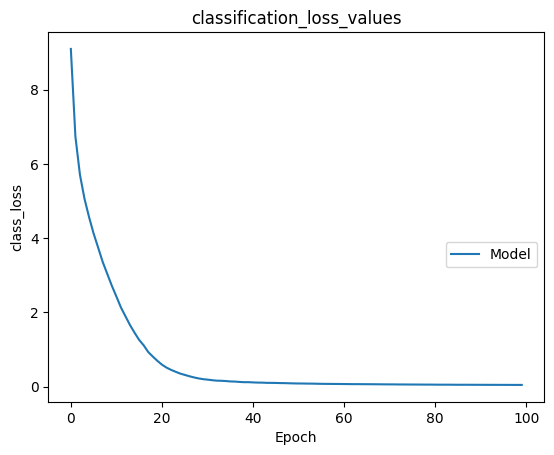

In [43]:
# Plot the data
plt.plot(epoch_number, class_loss_values, label='Model')  
plt.title('classification_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('class_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

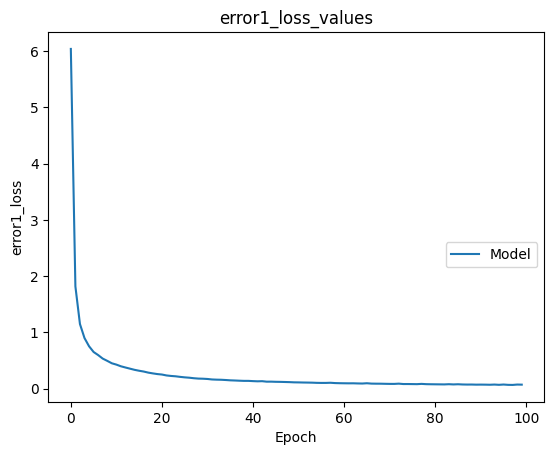

In [44]:
# Plot the data
plt.plot(epoch_number, error1_loss_values, label='Model')  
plt.title('error1_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('error1_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

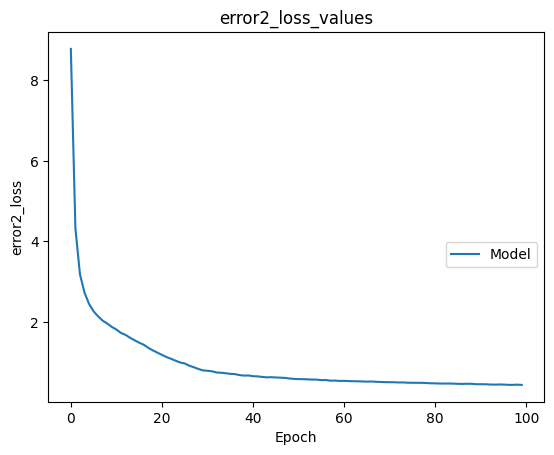

In [45]:
# Plot the data
plt.plot(epoch_number, error2_loss_values, label='Model')  
plt.title('error2_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('error2_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

#### Do more analysis on the final model to see how well it deals with each class

In [46]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
all_class_correct = list(0. for i in range(10))
all_class_total = list(0. for i in range(10))

with torch.no_grad():
    for images, labels in test_loader:
        images =images.cuda()
        labels =labels.cuda()
        
        _, _, outputs, _, _, _ = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)

        for i in range(batch_size):
            label = labels[i]
            all_class_correct[label] += c[i].item() # True is deemed as 1
            all_class_total[label] += 1



for i in range(10):
    print("all class total: ", all_class_total[i]," all class correct: ", all_class_correct[i])
    print('For network: Model Accuracy of %5s : %2d %%' % 
          (classes[i], 100 * all_class_correct[i] / all_class_total[i]))

all class total:  1000.0  all class correct:  819.0
For network: Model Accuracy of     0 : 81 %
all class total:  1000.0  all class correct:  908.0
For network: Model Accuracy of     1 : 90 %
all class total:  1000.0  all class correct:  699.0
For network: Model Accuracy of     2 : 69 %
all class total:  1000.0  all class correct:  661.0
For network: Model Accuracy of     3 : 66 %
all class total:  1000.0  all class correct:  748.0
For network: Model Accuracy of     4 : 74 %
all class total:  1000.0  all class correct:  647.0
For network: Model Accuracy of     5 : 64 %
all class total:  1000.0  all class correct:  837.0
For network: Model Accuracy of     6 : 83 %
all class total:  1000.0  all class correct:  799.0
For network: Model Accuracy of     7 : 79 %
all class total:  1000.0  all class correct:  883.0
For network: Model Accuracy of     8 : 88 %
all class total:  1000.0  all class correct:  870.0
For network: Model Accuracy of     9 : 87 %


#### Visualize the performance on each class

all_class_correct [81.9, 90.8, 69.9, 66.1, 74.8, 64.7, 83.7, 79.9, 88.3, 87.0]


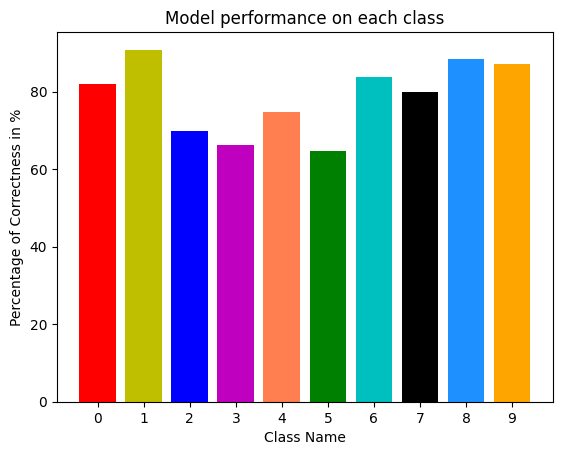

In [47]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

for i, x in enumerate(all_class_correct):
    all_class_correct[i] = 100 * all_class_correct[i] / all_class_total[i]
print('all_class_correct', all_class_correct)


plt.bar(classes, all_class_correct, color=['r','y','b','m','coral','g','c','k','dodgerblue','orange'])
plt.title('Model performance on each class')
plt.xlabel('Class Name')#x轴
plt.ylabel('Percentage of Correctness in %')#y轴

plt.show()